# Detección de perfiles falsos en instagram
Dataset: https://www.kaggle.com/datasets/free4ever1/instagram-fake-spammer-genuine-accounts

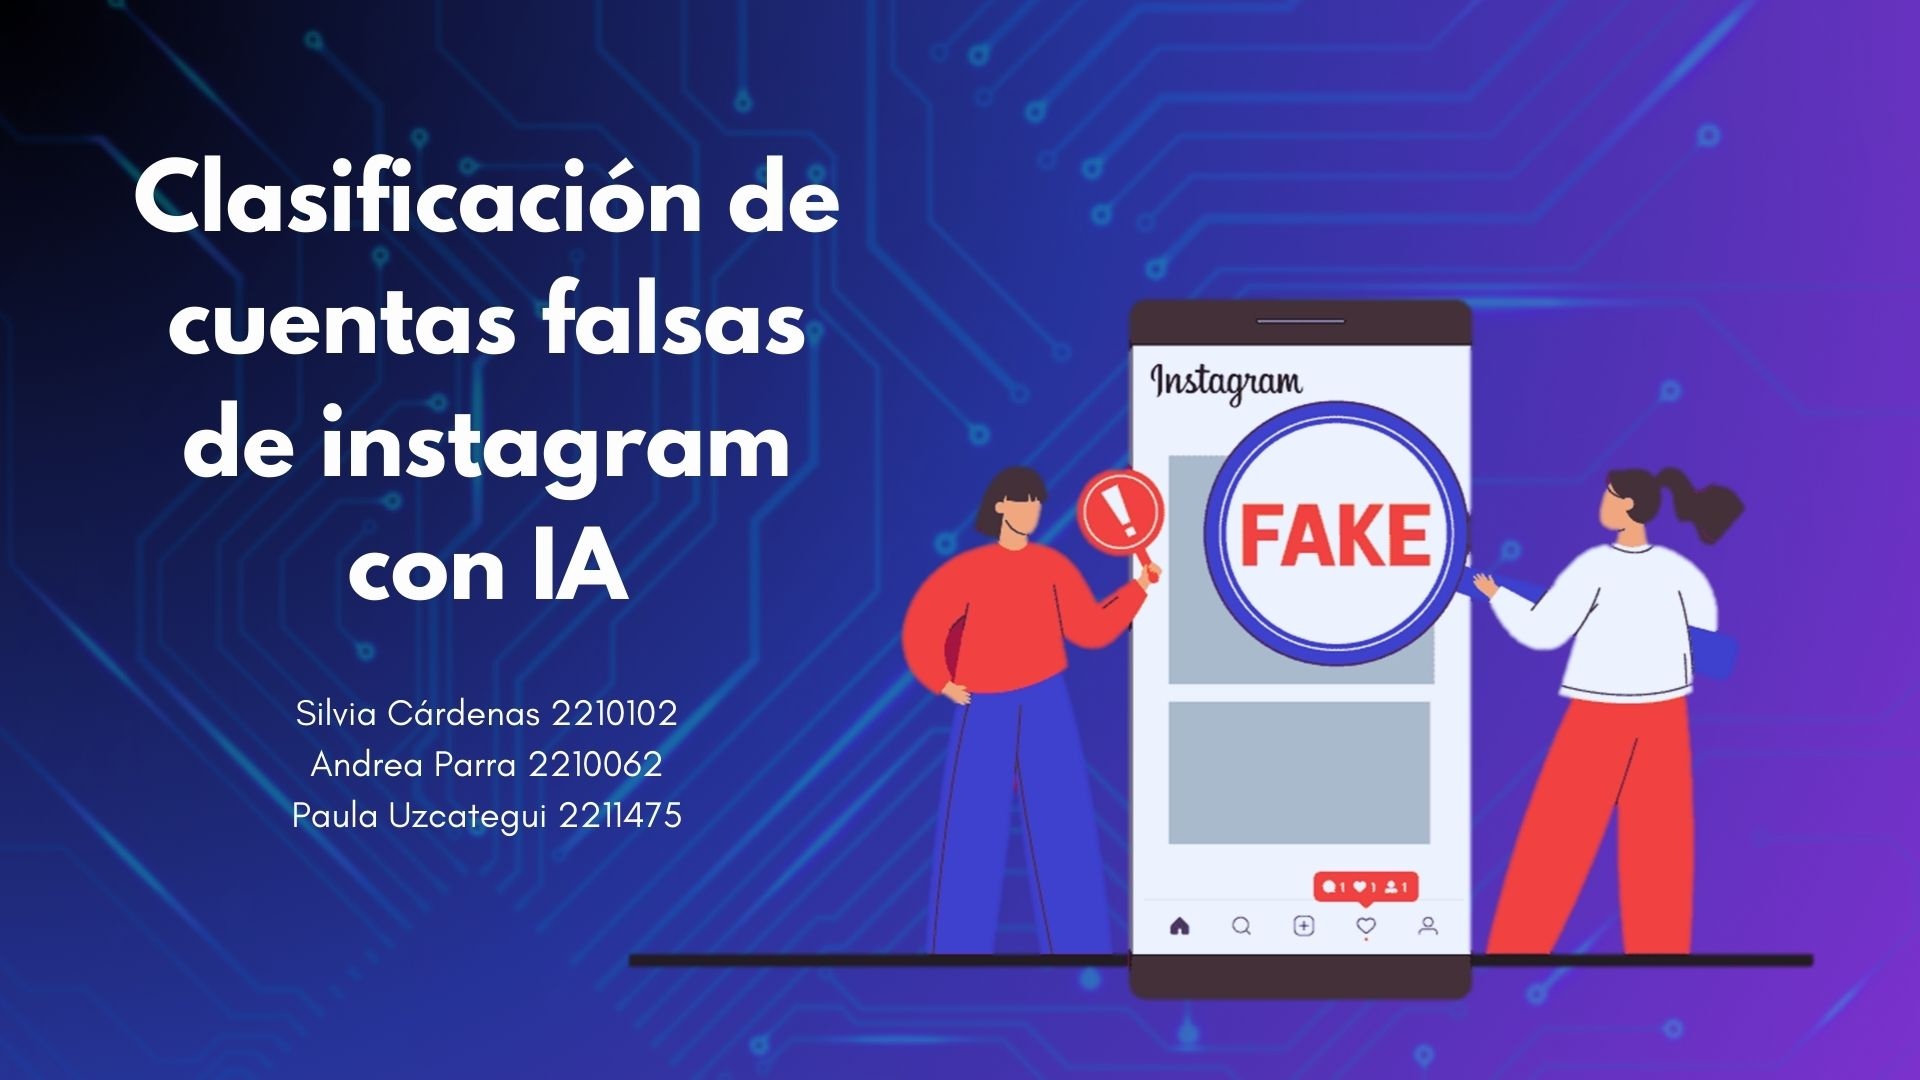

## Cargar librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy import stats
import random
random.seed(42)

In [ ]:
sns.set_theme()

# 📑​ Dataset

**Descripción de las Columnas**
1. `profile_pic`: (booleano) si el usuario tiene una foto de perfil (1 para sí, 0 para no).

2. `num_ratio_username`: (flotante) proporción de caracteres numéricos en el nombre de usuario.

3. `fullname_words`: (entero) número de palabras en el nombre completo del usuario.

4. `num_ratio_fullname`: (flotante) proporción de caracteres numéricos en el nombre completo del usuario.

5. `name_is_username`: (booleano) si el nombre completo del usuario es igual a su nombre de usuario (1 para sí, 0 para no).

6. `description_length`: (entero) longitud de la descripción del perfil del usuario (en caracteres).

7. `external_url`: (booleano) si el usuario tiene una URL externa en su perfil (1 para sí, 0 para no).

8. `private`: (booleano) si el perfil del usuario es privado (1 para sí, 0 para no).

9. `posts`: (entero) número de publicaciones realizadas por el usuario.

10. `followers`: (entero) número de seguidores que tiene el usuario.

11. `follows`: (entero) número de cuentas que el usuario está siguiendo.

12. `fake`:(booleano) si la cuenta del usuario se clasifica como falsa o no (1 para falsa, 0 para genuina).

In [3]:
d_train = pd.read_csv("https://drive.google.com/uc?id=1qQQ-pwn1UCms-hi-f8I4oncTtCnY9bPH&export=download&authuser=0", sep=",")
d_test = pd.read_csv("https://drive.google.com/uc?id=1RqyKv_TgAoC_CLbRvWZXJLF2UnkeA9MI&export=download&authuser=0", sep=",")
d = pd.concat([d_train, d_test])

new_column_names = {'profile pic': 'profile_pic',
                    'nums/length username':'num_ratio_username',
                    'fullname words':'fullname_words',
                    'nums/length fullname': 'num_ratio_fullname',
                    'name==username':'name_is_username',
                    'description length': 'description_length',
                    'external URL': 'external_url',
                    '#posts': 'posts',
                    '#followers':'followers',
                    '#follows':'follows'
                    }
d.rename(columns = new_column_names, inplace = True)

In [ ]:
d.head(5)

,profile_pic,num_ratio_username,fullname_words,num_ratio_fullname,name_is_username,description_length,external_url,private,posts,followers,follows,fake
0,1,0.00,2,0.0,0,126,1,0,230,2284,130,0
1,1,0.29,2,0.0,0,9,0,1,7,221,244,1
2,0,0.33,2,0.0,0,0,0,0,0,82,6,1
3,1,0.27,1,0.0,0,19,0,0,8,126,860,1
4,0,0.36,1,0.0,0,0,0,0,8,39,17,1


In [4]:
print("Perfiles falsos:", d[d['fake'] == 1].shape[0])
print("Perfiles reales:", d[d['fake'] == 0].shape[0])
print("Total de filas:", d.shape)

Perfiles falsos: 348
Perfiles reales: 348
Total de filas: (696, 12)


### ​📊​ ​Visualizar los datos

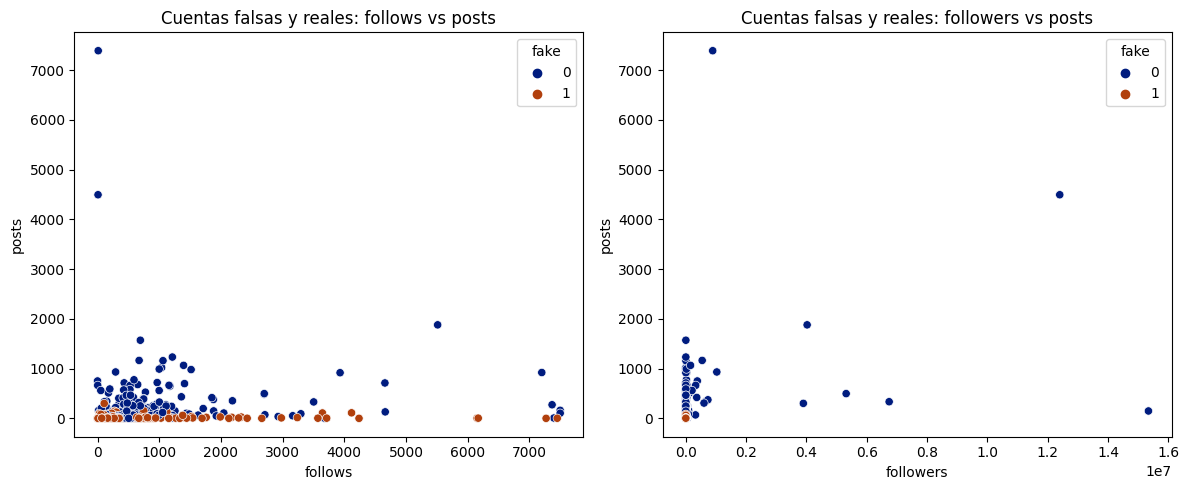

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.scatterplot(x="follows", y="posts", hue="fake", palette="dark",
data=d).set(title='Cuentas falsas y reales: follows vs posts')

plt.subplot(122)
sns.scatterplot(x="followers", y="posts", hue="fake", palette="dark",
 data=d).set(title='Cuentas falsas y reales: followers vs posts')

plt.tight_layout()
plt.show()

### ✂️​ Eliminando outliers
Encontramos mejores resultados para algunos modelos si quitabamos los outliers de los datos

In [6]:
Q1 = d.quantile(0.25)
Q3 = d.quantile(0.75)
IQR = Q3 - Q1

# umbral para quitar los outliers, usamos 1.5 por defecto
threshold = 1.5

# Identificar los outliers de cada columna
outliers = ((d < (Q1 - threshold * IQR)) | (d > (Q3 + threshold * IQR)))

# Solo quitamos outliers de las columnas numericas
outliers = outliers[['description_length','followers','posts','follows','num_ratio_username', 'fullname_words','num_ratio_fullname']]
df_no_outliers = d[~outliers.any(axis=1)]

print("Con outliers #filas:", d.shape[0])
print("Sin outliers #filas", df_no_outliers.shape[0])
print("Perfiles falsos:", df_no_outliers[df_no_outliers['fake'] == 1].shape[0])
print("Perfiles reales:", df_no_outliers[df_no_outliers['fake'] == 0].shape[0])

Con outliers #filas: 696
Sin outliers #filas 428
Perfiles falsos: 247
Perfiles reales: 181


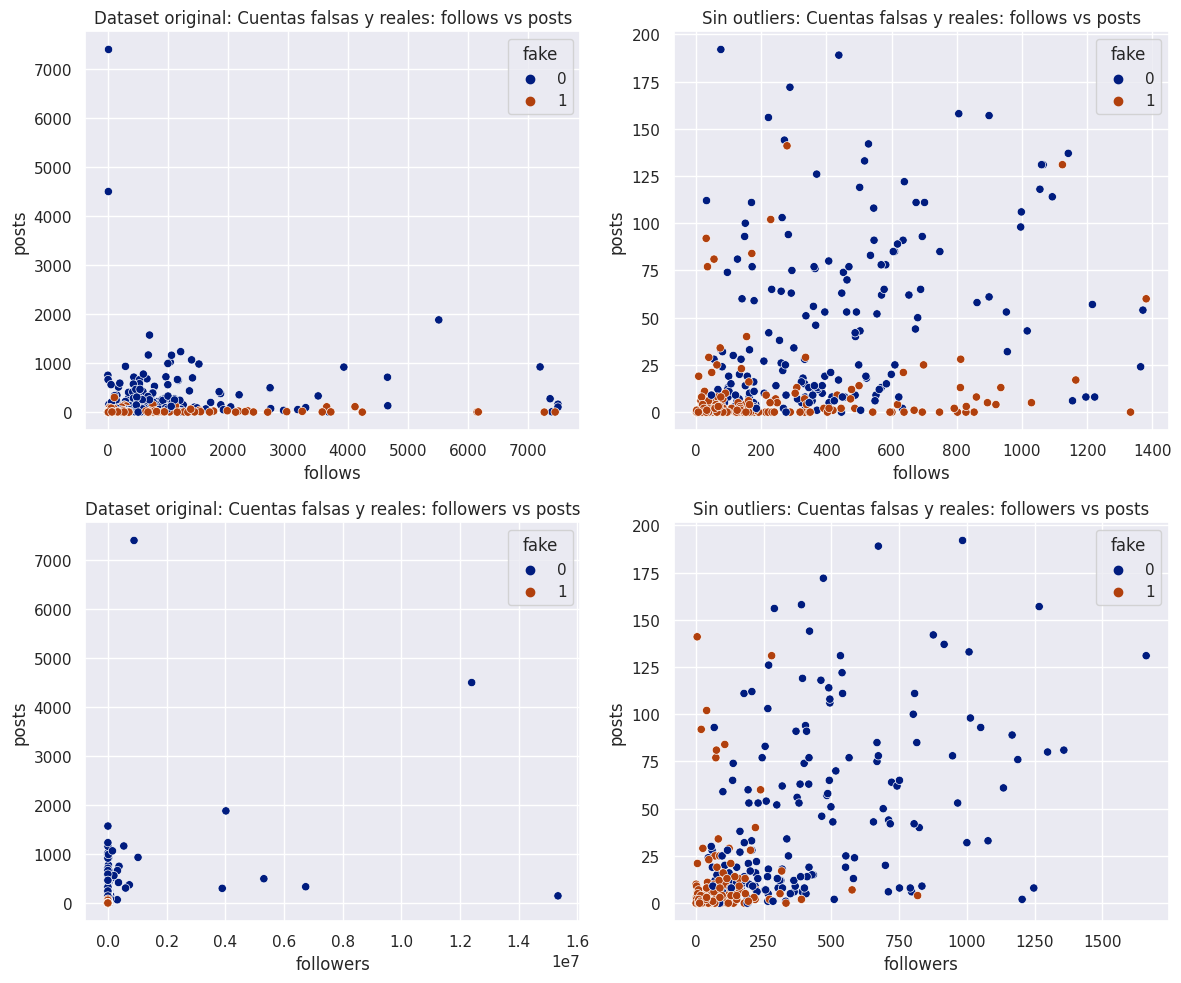

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(221)
sns.scatterplot(x="follows", y="posts", hue="fake", palette="dark", data=d).set(title='Dataset original: Cuentas falsas y reales: follows vs posts')
plt.subplot(222)
sns.scatterplot(x="follows", y="posts", hue="fake", palette="dark", data=df_no_outliers).set(title='Sin outliers: Cuentas falsas y reales: follows vs posts')

plt.subplot(223)
sns.scatterplot(x="followers", y="posts", hue="fake", palette="dark", data=d).set(title='Dataset original: Cuentas falsas y reales: followers vs posts')

plt.subplot(224)
sns.scatterplot(x="followers", y="posts", hue="fake", palette="dark", data=df_no_outliers).set(title='Sin outliers: Cuentas falsas y reales: followers vs posts')

plt.tight_layout()
plt.show()

### 📏​ Metricas:
Las metricas relevantes para nuestro proyectos

* **Accuracy**: que tan seguido nuestro modelo predice correctamente. Nos sirve también porque tenemos el mismo número de perfiles falsos y reales en el dataset.

* **Presición**: es buena para detectar los falsos positivos. Nos sirve para ver si estamos detectando perfiles falsos como verdaderos.

  $Precision = \frac{True Positive}{True Positive + False Positive}$
* **Recall**: es buena para detectar los falsos negativos. Nos sirve para ver si estamos detectando perfiles verdaderos como falsos.

  $Recall = \frac{True Positive}{True Positive + False Negative}$

### Creando partición

In [7]:
d = shuffle(d)
d.reset_index(inplace=True, drop=True)
# Con todo el dataset
y = d["fake"]
X = d.drop("fake", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [8]:
# Sin outliers
y_no = df_no_outliers["fake"]
X_no = df_no_outliers.drop("fake", axis=1)
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_no, y_no, test_size=0.2, random_state=21)

# 🦾 Modelos
A continuación los modelos de inteligencia artificial que probamos para clasificación:

### Probar estimador
Funcion para probar estimador

In [9]:
def metricas_estimador(est1, X, y):
  s = cross_val_score(est1, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
  print("accuracy         %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
  s = cross_val_score(est1, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(precision_score))
  print("Precision score  %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
  s = cross_val_score(est1, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(recall_score))
  print("Recall score     %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

## Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
est1 = GaussianNB()
est1.fit(X_train,y_train)
print(accuracy_score(est1.predict(X_test), y_test))
metricas_estimador(est1,X,y)

0.7214285714285714
accuracy         0.684 (+/- 0.05062)
Precision score  0.614 (+/- 0.05798)
Recall score     0.976 (+/- 0.03020)


In [ ]:
est1 = GaussianNB()
est1.fit(X_train_no,y_train_no)
print(accuracy_score(est1.predict(X_test_no), y_test_no))
metricas_estimador(est1,X,y)

0.8604651162790697
accuracy         0.681 (+/- 0.07025)
Precision score  0.615 (+/- 0.07113)
Recall score     0.974 (+/- 0.02385)


## Decision Tree

In [ ]:
#Desicion tree no es sensible a los outliers :)
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=4, criterion='log_loss')
dt.fit(X_train,y_train)
print(accuracy_score(dt.predict(X_test), y_test))
metricas_estimador(dt,X,y)

0.9285714285714286
accuracy         0.907 (+/- 0.03980)
Precision score  0.930 (+/- 0.03689)
Recall score     0.890 (+/- 0.03655)


## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=37,criterion='entropy',n_estimators=94)
rf.fit(X_train, y_train)
print(accuracy_score(rf.predict(X_test), y_test))
metricas_estimador(rf,X,y)

0.95
accuracy         0.928 (+/- 0.03174)
Precision score  0.934 (+/- 0.03166)
Recall score     0.908 (+/- 0.05083)


## Support Vector Machine

In [18]:
from sklearn.svm import SVC
sv = SVC(kernel="rbf",  C=959.1877)
sv.fit(X_train, y_train)
print(accuracy_score(sv.predict(X_test), y_test))
metricas_estimador(sv,X,y)

0.55
accuracy         0.589 (+/- 0.05908)
Precision score  0.551 (+/- 0.07971)
Recall score     0.979 (+/- 0.03763)


In [17]:
# svm es  muy sensible a los outliers
sv2 = SVC(kernel="rbf",  C=959.1877)
sv2.fit(X_train_no, y_train_no)
print(accuracy_score(sv2.predict(X_test_no), y_test_no))
metricas_estimador(sv2,X_no,y_no)
print("Con outliers: ")
metricas_estimador(sv2,X,y)

0.8837209302325582
accuracy         0.897 (+/- 0.03750)
Precision score  0.879 (+/- 0.04475)
Recall score     0.949 (+/- 0.03920)
Con outliers: 
accuracy         0.595 (+/- 0.04806)
Precision score  0.553 (+/- 0.05392)
Recall score     0.977 (+/- 0.02140)


## Deep learning

# Red neuronal secuencial para clasificación



###Creación modelo

In [ ]:
#numero de clases vector de 2 [1][0] / [0][1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
y_train_shape = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_shape = tf.keras.utils.to_categorical(y_test, num_classes=2)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 11)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               1536      
                                                                 
 dense_7 (Dense)             (None, 2)                 258       
                                                                 
Total params: 1794 (7.01 KB)
Trainable params: 1794 (7.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Entrenamiento

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              #gt 0 o 1 ->'binary_crossentropy'
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train_shape, epochs=10)
test_loss, test_acc = model.evaluate(X_test, y_test_shape)
print( 'Test accuracy:', test_acc, " Test loss: ", test_loss)

Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.5970 - accuracy: 0.7248
Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5074 - accuracy: 0.7104
Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5311 - accuracy: 0.7608
Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5314 - accuracy: 0.7464
Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5467 - accuracy: 0.7356
Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5766 - accuracy: 0.7140
Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5409 - accuracy: 0.7608
Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.5137 - accuracy: 0.8201
Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.4980 - accuracy: 0.7932
Epoch 10/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6045 - accuracy: 0.8429
Test accuracy: 0.8428

###Prueba

Epoch 1/20
18/18 [==============================] - 0s 6ms/step - loss: 0.6792 - accuracy: 0.4946 - val_loss: 0.7725 - val_accuracy: 0.5429
Epoch 2/20
18/18 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4946 - val_loss: 0.7719 - val_accuracy: 0.5429
Epoch 3/20
18/18 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.4946 - val_loss: 0.7697 - val_accuracy: 0.5429
Epoch 4/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5018 - val_loss: 0.7705 - val_accuracy: 0.5429
Epoch 5/20
18/18 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.5072 - val_loss: 0.7693 - val_accuracy: 0.5429
Epoch 6/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.5360 - val_loss: 0.7503 - val_accuracy: 0.5857
Epoch 7/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5941 - accuracy: 0.6421 - val_loss: 0.6724 - val_accuracy: 0.7071
Epoch 8/20
18/18 [==

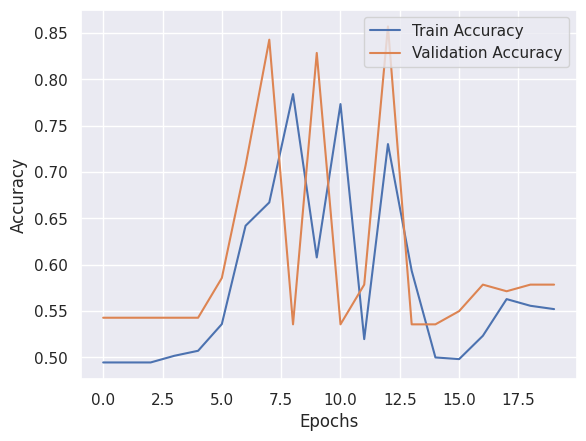

In [ ]:
history = model.fit(X_train,
          y_train_shape,
          #se puede aumentar el numero de epoch, pero se puede volver muy lento
          epochs=20,
          batch_size=32,
          validation_data=(X_test, y_test_shape))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

###En busca de un mejor accuracy

Entrenamiento:
Epoch 1/10
18/18 [==============================] - 6s 272ms/step - loss: 6.8050 - accuracy: 0.5054
Epoch 2/10
18/18 [==============================] - 2s 132ms/step - loss: 6.2759 - accuracy: 0.5090
Epoch 3/10
18/18 [==============================] - 2s 131ms/step - loss: 6.9044 - accuracy: 0.5054
Epoch 4/10
18/18 [==============================] - 2s 132ms/step - loss: 5.2721 - accuracy: 0.5054
Epoch 5/10
18/18 [==============================] - 2s 131ms/step - loss: 2.4055 - accuracy: 0.6277
Epoch 6/10
18/18 [==============================] - 4s 200ms/step - loss: 3.4010 - accuracy: 0.6007
Epoch 7/10
18/18 [==============================] - 3s 161ms/step - loss: 1.4101 - accuracy: 0.6853
Epoch 8/10
18/18 [==============================] - 2s 133ms/step - loss: 0.6968 - accuracy: 0.7806
Epoch 9/10
18/18 [==============================] - 2s 129ms/step - loss: 0.6872 - accuracy: 0.7968
Epoch 10/10
18/18 [==============================] - 2s 127ms/step - loss: 0.8670 - a

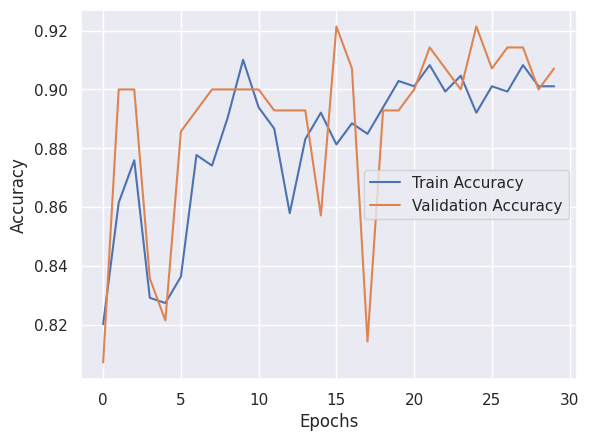

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= (X_train.shape[1],)),
    tf.keras.layers.Dense(5000, activation=tf.nn.relu),
    tf.keras.layers.Dense(2500, activation=tf.nn.relu),
    tf.keras.layers.Dense(1500, activation=tf.nn.relu),
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(optimizer=tf.keras.optimizers.SGD(),
              #gt 0 o 1 ->'binary_crossentropy'
              loss='binary_crossentropy',
              metrics=['accuracy'])
print('Entrenamiento:')
model.fit(X_train, y_train_shape, epochs=10)

history = model.fit(X_train,
          y_train_shape,
          epochs=30,
          batch_size=32,
          validation_data=(X_test, y_test_shape))

print('Verificacion:')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

###Matriz de confusión

5/5 [==============================] - 0s 54ms/step
matrix de confusión en test
 [[54  9]
 [ 4 73]]


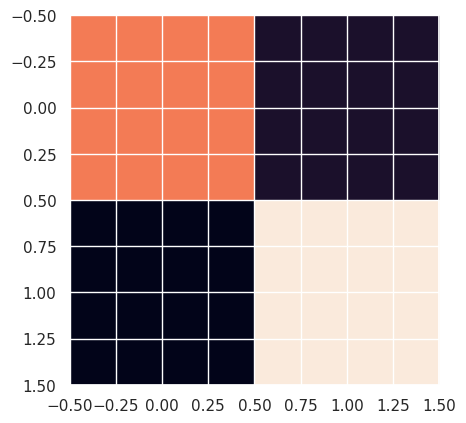

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(X_test)
labels_pred = np.argmax(predictions, axis=1)
#confusion_matrix(gt,predicciones)
cm_test = confusion_matrix(y_test, labels_pred)
print ("matrix de confusión en test\n", cm_test)
plt.imshow(cm_test)

# Agrupamiento sin outliers
Los algoritmos de agrupamiento y reducción de dimensionalidad son sensibles a los outliers, por lo que esta sección la implementamos con el dataset al que le habiamos quitado los outliers.

###PCA

In [ ]:
def best_c(X,n):
  pca = PCA()
  pca.fit_transform(X)
  varianza_explicativa = pca.explained_variance_ratio_
  explicativa_acumulada=[]
  for k in range(n):
    i=sum(varianza_explicativa[:k])
    explicativa_acumulada.append(i)
  plt.plot(varianza_explicativa*-1)
  plt.title("PCA vs total explained variance")
  plt.xlabel("Num. principal components ($k$)")
  plt.ylabel("Explained variance")
  # return explicativa_acumulada, varianza_explicativa

(0.0, 5.0)

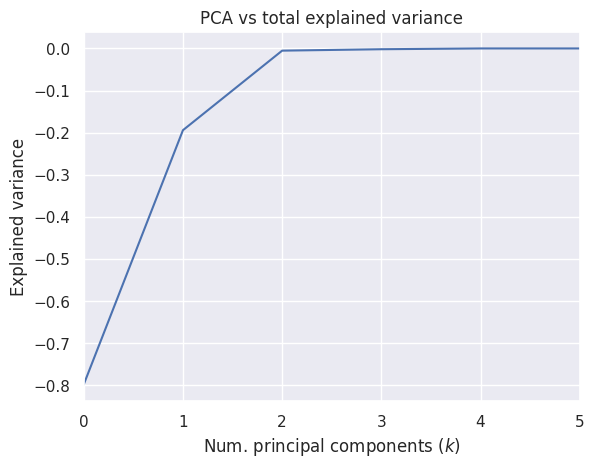

In [ ]:
best_c(X_no,5) #1 o 2 componente ya tenemos suficiente
plt.xlim((0,5))

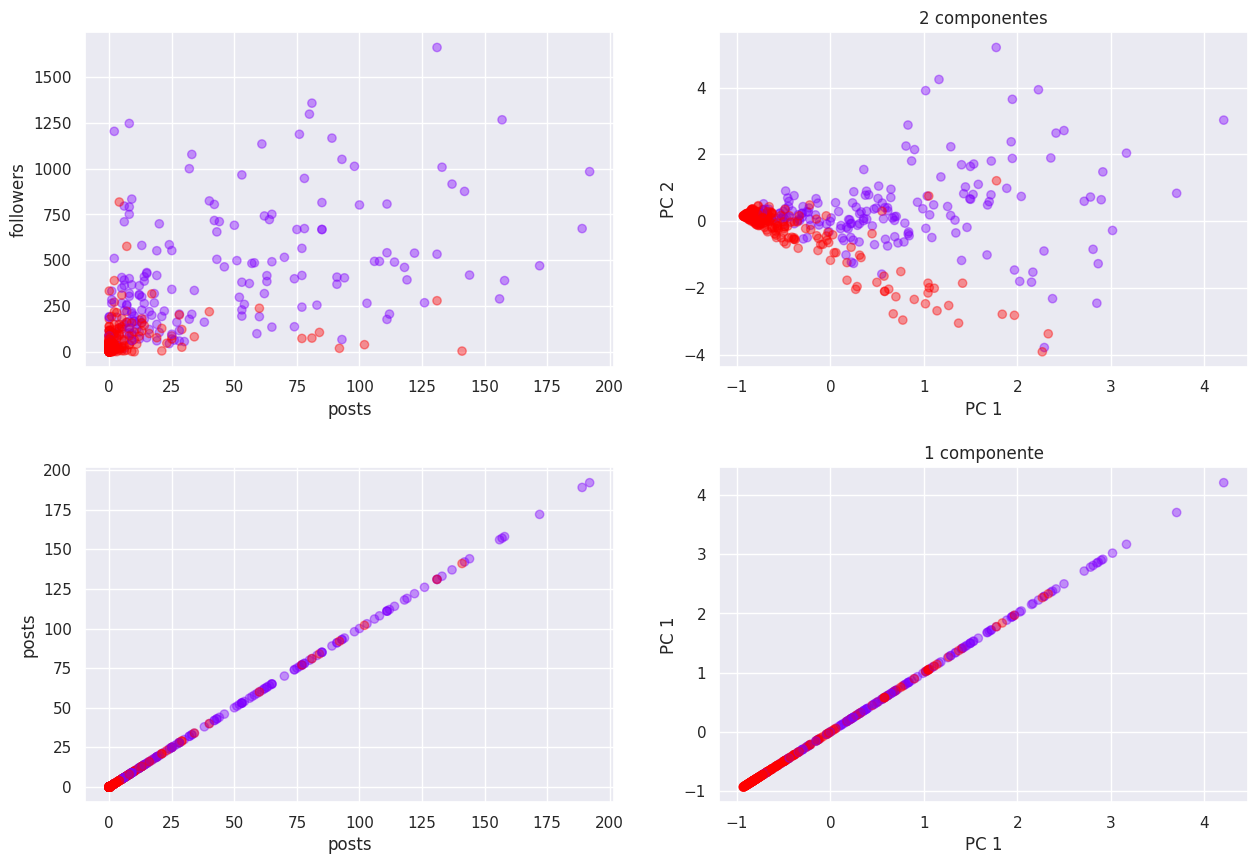

In [ ]:
pca_fakes=PCA(n_components= 2, whiten=True)
X_pca = pca_fakes.fit_transform(X_no)
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.scatter(X_no['posts'], X_no['followers'], c=y_no, alpha=0.4,cmap='rainbow')
plt.xlabel('posts')
plt.ylabel('followers')

plt.subplot(222)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_no, alpha=0.4,cmap='rainbow')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title('2 componentes')

plt.subplot(223)
plt.scatter(X_no['posts'], X_no['posts'], c=y_no, alpha=0.4,cmap='rainbow')
plt.xlabel('posts')
plt.ylabel('posts')

plt.subplot(224)
plt.scatter(X_pca[:, 0], X_pca[:, 0], c=y_no, alpha=0.4,cmap='rainbow')
plt.xlabel("PC 1")
plt.ylabel("PC 1")
plt.title('1 componente')
plt.subplots_adjust(hspace=0.3)
plt.show()

###Kmeans
Igual me parece que la clasificacion con y sin PCA es bastante mala...

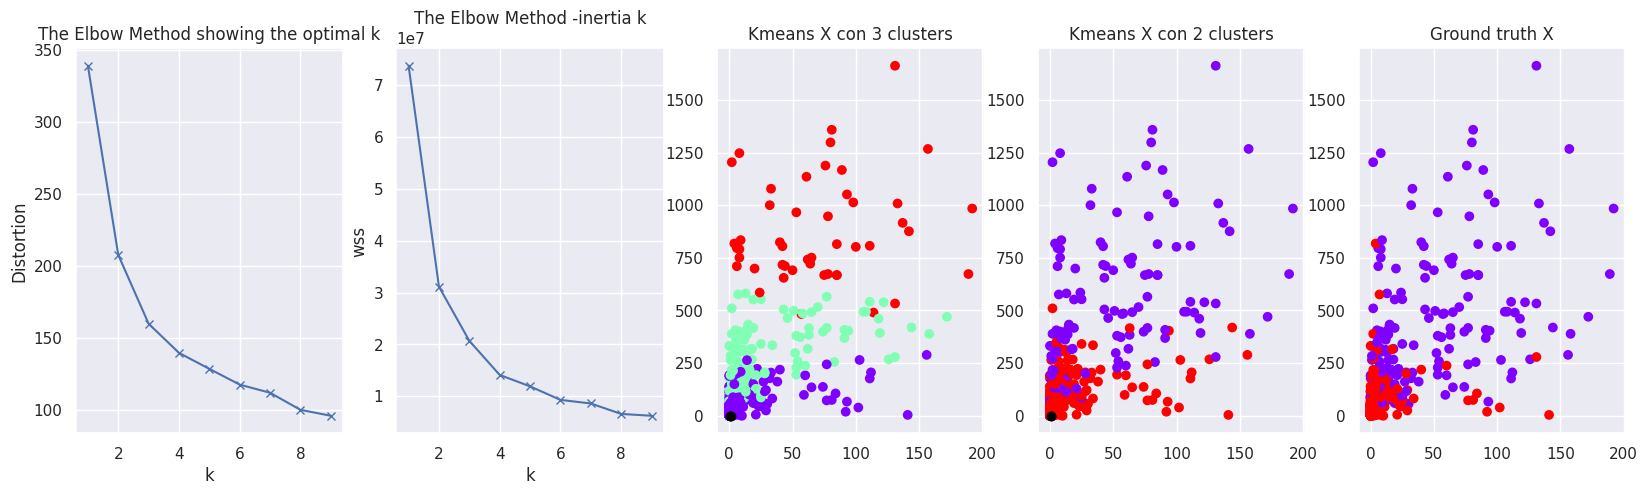

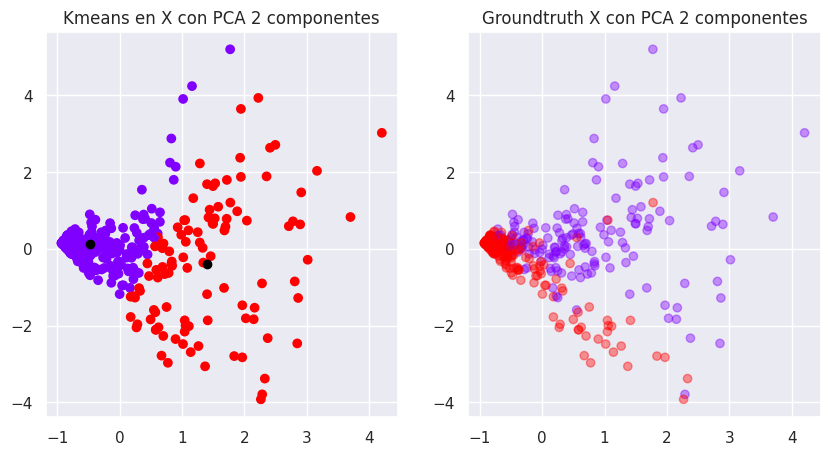

In [ ]:
distortions = []
wss = [] #Within-Cluster-Sum of Squared
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init='auto').fit(X_no)
    kmeanModel.fit(X_no)
    distortions.append(sum(np.min(cdist(X_no, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_no.shape[0])
    wss.append(kmeanModel.inertia_)

plt.figure(figsize=(20,5))
plt.subplot(151)
plt.plot(K, distortions, 'bx-'); plt.xlabel('k');plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.subplot(152) #wss -> promedio distancias entre clusters
plt.plot(K, wss, 'bx-'); plt.xlabel('k');plt.ylabel('wss')
plt.title('The Elbow Method -inertia k')


plt.subplot(153)
kmeanModel = KMeans(n_clusters=3, n_init='auto')
kmeanModel.fit(X_no)
plt.scatter(X_no['posts'], X_no['followers'], c=kmeanModel.labels_, cmap='rainbow');
plt.scatter(kmeanModel.cluster_centers_[:,0] ,kmeanModel.cluster_centers_[:,1], color='black')
plt.title("Kmeans X con 3 clusters")

plt.subplot(154)
kmeanModel = KMeans(n_clusters=2, n_init='auto')
kmeanModel.fit(X_no)
plt.scatter(X_no['posts'], X_no['followers'], c=kmeanModel.labels_, cmap='rainbow');
plt.scatter(kmeanModel.cluster_centers_[:,0] ,kmeanModel.cluster_centers_[:,1], color='black')
plt.title("Kmeans X con 2 clusters")

plt.subplot(155)
plt.scatter(X_no['posts'], X_no['followers'], c=y_no, cmap='rainbow');
plt.title("Ground truth X")
plt.show()


# quiero mostrar Kmeans pero aplicado con el PCA de dos componentes
plt.figure(figsize=(10,5))
plt.subplot(121)
kmeanModel = KMeans(n_clusters=2, n_init='auto')
kmeanModel.fit(X_pca)
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeanModel.labels_, cmap='rainbow');
plt.scatter(kmeanModel.cluster_centers_[:,0] ,kmeanModel.cluster_centers_[:,1], color='black')
plt.title("Kmeans en X con PCA 2 componentes")

plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_no, alpha=0.4,cmap='rainbow')
plt.title("Groundtruth X con PCA 2 componentes")
plt.show()

### DBScan
Realmente es de esperarse que no de buenos resultados, ya que nuestro dataset no forma "caminitos"

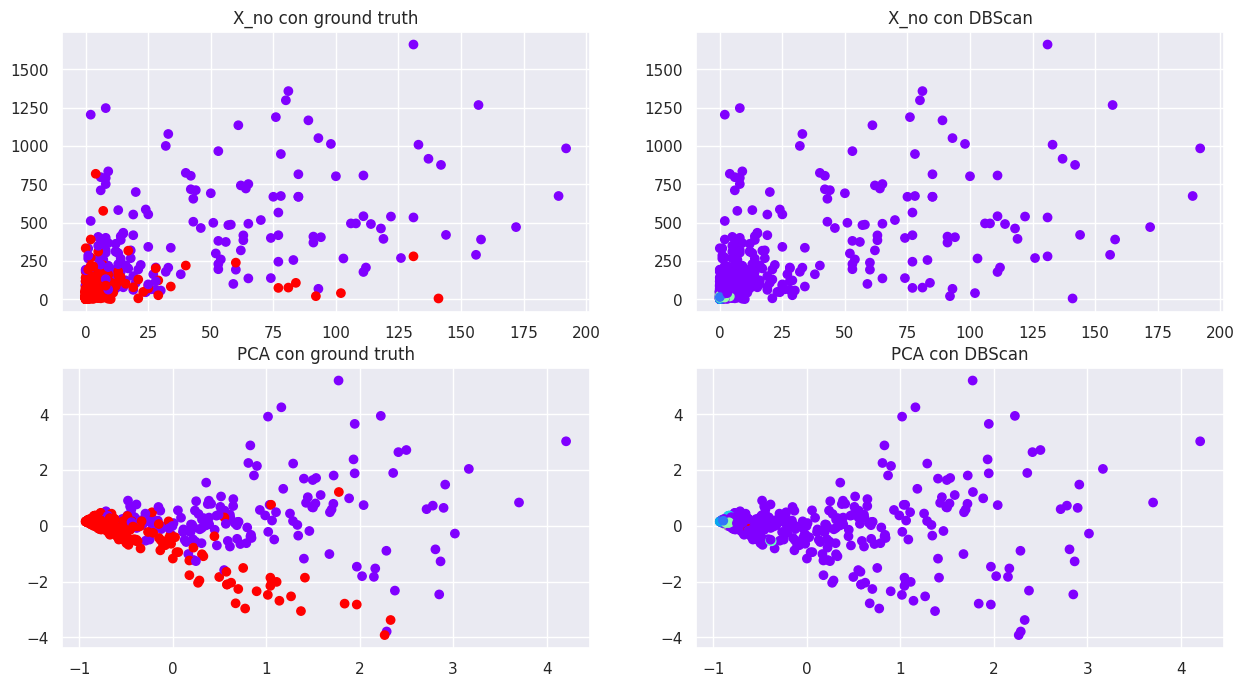

In [ ]:
X_scaled = StandardScaler().fit_transform(X_no)
DBS = DBSCAN(eps=5,min_samples=3)
DBS.fit(X_no)

plt.figure(figsize=(15,8))
plt.subplot(221)
plt.title('X_no con ground truth')
plt.scatter(X_no['posts'], X_no['followers'], c=y_no, cmap='rainbow')
plt.subplot(222)
plt.title('X_no con DBScan')
plt.scatter(X_no['posts'],X_no['followers'], c=DBS.labels_, cmap='rainbow')
plt.subplot(223)
plt.title('PCA con ground truth')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_no, cmap='rainbow') #pca 2 componentes
plt.subplot(224)
plt.title('PCA con DBScan')
plt.scatter(X_pca[:, 0],X_pca[:, 1], c=DBS.labels_, cmap='rainbow')